In [1]:
# install & load required packages
devtools::install_github("WorldWeatherAttribution/rwwa")
suppressMessages(library(rwwa))

# Analysis of a single time series

## Load & plot data

_The model fitting function takes as its main input a data.frame with named columns containing the variable and covariates of interest, and a column 'year' containing integer-valued years_

_In this example, the variable of interest is the June-November SPEI each year, and we'll use the 4-year smoothed GMST and the June-November mean of the detrended Nino3.4 index as covariates_

In [3]:
# load covariate data
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

nino <- read.csv("ts/nino_6monthly.csv", col.names = c("year", "nino"))

# load time series of interest
ts <- read.csv("ts/cx_spei6_ms.csv")

# combine into single dataframe
df <- merge(merge(gmst, nino), ts)

_We expect the SPEI to be particularly low during El Nino events, but not necessarily higher in a La Nina year than in a neutral year. We create a new covariate to reflect this, by setting negative values of the Nino3.4 index to zero._

In [3]:
df$nino_pos <- df$nino
df$nino_pos[df$nino <= 0] <- 0

_The `prep_window` function allows you to customise the number of rows and columns displayed in a Python notebook, and also the height and width of each figure. You can also set graphical parameters inside this function._

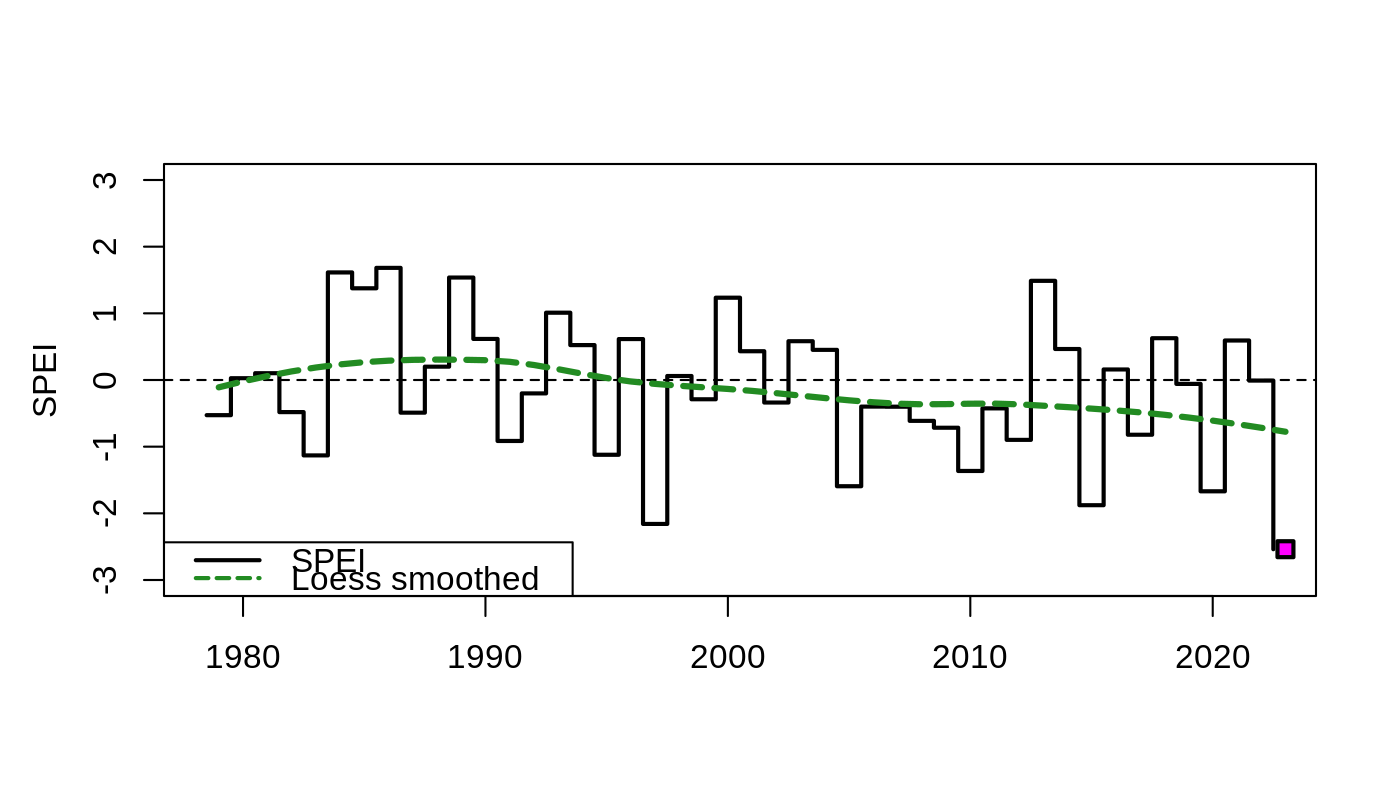

In [7]:
prep_window(c(1,1), w = 7)

# plot the yearly time series    
plot(df$year-0.5, df$spei, type = "s", lwd = 2, ylim = c(-3,3), xlab = "", ylab = "SPEI", bg = "white")
abline(h = 0, lty = 2)

# add a point for the event of interest (2023 drought)
points(df[df$year == 2023,c("year", "spei")],pch = 22, bg = "magenta", lwd = 2, cex = 1.2)

# It's useful to add a simple Loess smoother to see if there is any trend over time
lines(df$year, fitted(loess(spei ~ year, df)), col = "forestgreen", lty = "32", lwd = 3)

legend("bottomleft", c("SPEI", "Loess smoothed"), lty = c("solid","32"), lwd = 2, col = c("black", "forestgreen"))

## Fitting and choosing a model

_We use the `fit_ns` function to fit a nonstationary distribution to the data_

_We need to specify the parametric form of the distribution; whether the distribution shifts linearly with GMST or scales exponentially with fixed dispersion; specify the data.frame containing the data, the name of the columns containing the predictand and covariates, and whether we're interested in the lower tail of extremes._

In [8]:
# All methods are fully documented so that you can check the optional arguments
?fit_ns

fit_ns {rwwa},R Documentation
dist,String defining the parametric form to be fitted (currently only implemented for GEV and Gaussian)
type,String defining the relationship between the fitted values and the covariate (currently implemented: 'shift' and 'fixeddisp')
data,Data.frame with named columns containing the variable and any covariates of interest
varnm,String identifying the dependent variable (must be a column name in 'data')
covnm,String or vector of strings identifying the predictors (must be column names in 'data')
lower,Boolean indicating whether to evaluate the lower tail of the data or not: default is F (evaluate the upper tail).
ev_year,(optional) Scalar specifying the year of the event of interest; default is to use the value from the last row of 'data'
ev,(optional) Scalar specifying the magnitude of the event of interest; default is to use the value corresponding to 'ev_year'
method,String defining the method to be used by 'optim' to maximise the log-likelihood: default is 'BFGS'


_We'll test several candidate models: one in which SPEI depends only on GMST, one in which the 6-month Nino3.4 index is also included, and one in which the positive 6-month Nino3.4 index is also included_

In [10]:
mdl_gmst <- fit_ns("norm", "shift", df, "spei", c("gmst"), lower = T)
mdl_nino <- fit_ns("norm", "shift", df, "spei", c("gmst", "nino"), lower = T)
mdl_ninopos <- fit_ns("norm", "shift", df, "spei", c("gmst", "nino_pos"), lower = T)

## Comparing the fitted models

_The package includes functions to check the AIC and variance explained ($R^2$) to see which model fits the data better: a lower AIC indicates a better model._

_In this case, the model with both GMST and positive El Nino covariates has the lowest AIC and the highest $R^2$ and adjusted $R^2$, with 27.7% of the variance explained by the predictors._

In [11]:
# combine the models into a list to make looping easier
models <- list("gmst" = mdl_gmst, "nino34" = mdl_nino, "elnino" = mdl_ninopos)

rbind("aic" = round(sapply(models, aic),1), round(sapply(models, rsquared),3))

,gmst,nino34,elnino
aic,129.700,128.400,121.700
r2,0.098,0.161,0.277
r2.adj,0.077,0.121,0.242


_We can plot the fitted models against the observations to make sure they look reasonable  
We can also include a Loess smoother to see if the fitted model accurately replicates the trend over time_

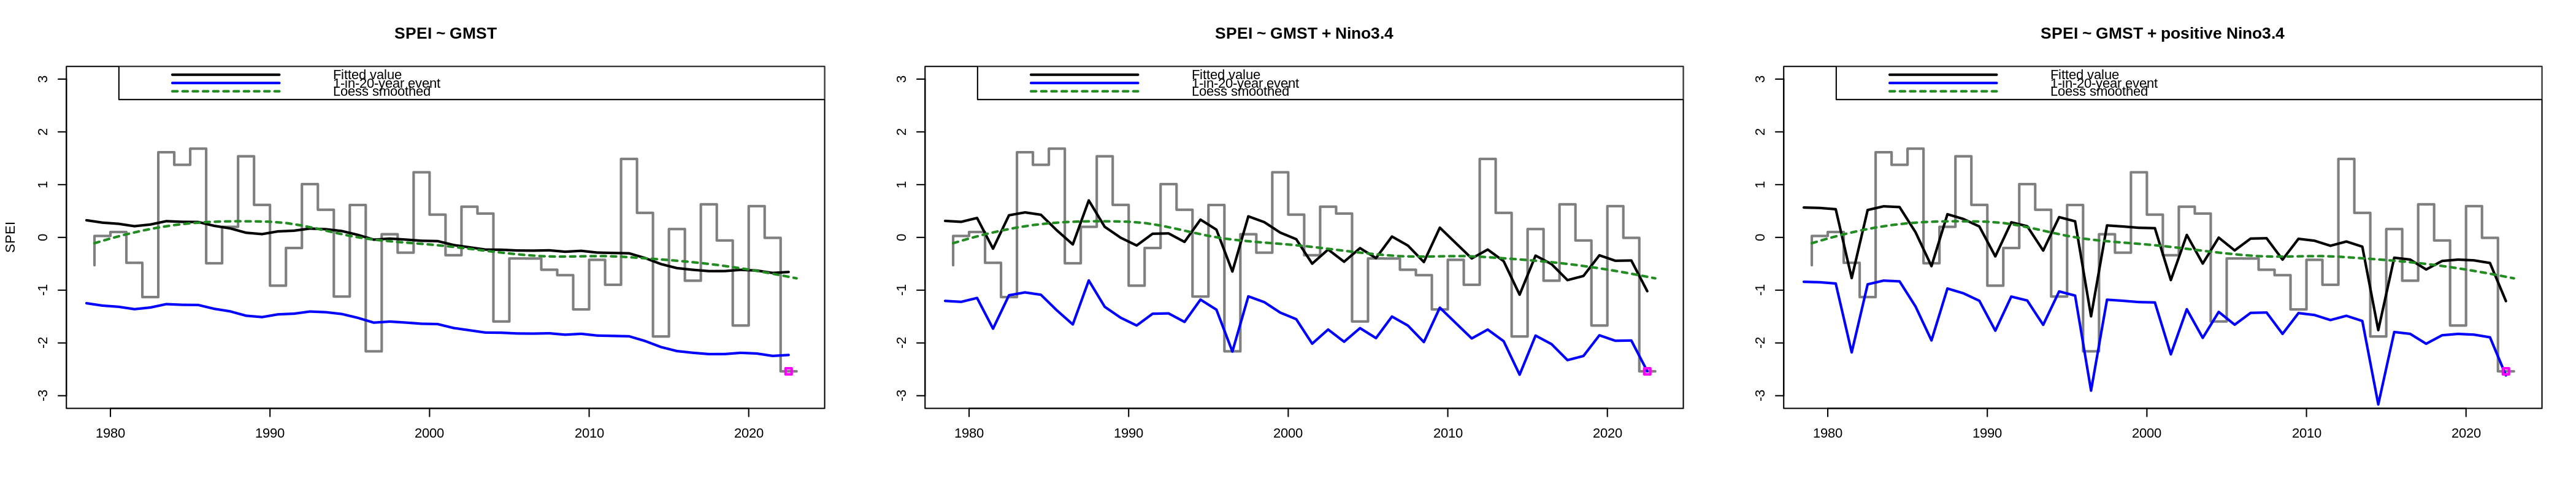

In [19]:
prep_window(c(1,3), w = 7)

plot_trend(mdl_gmst, xlab = "", ylab = "SPEI", ylim = c(-3,3), rp = c(20), add_loess = T, legend = "topright", main = "SPEI ~ GMST")
plot_trend(mdl_nino, xlab = "", ylab = "", ylim = c(-3,3), rp = c(20), add_loess = T, legend = "topright", main = "SPEI ~ GMST + Nino3.4")
plot_trend(mdl_ninopos, xlab = "", ylab = "", ylim = c(-3,3), rp = c(20), add_loess = T, legend = "topright", main = "SPEI ~ GMST + positive Nino3.4")


## Fitted trend vs covariates

_We can also plot the fitted trend against each covariate to check the fit visually_

_Use the `ci_cov` argument to add confidence intervals at x-values of interest (these are bootstrapped so will take a few seconds to run)_

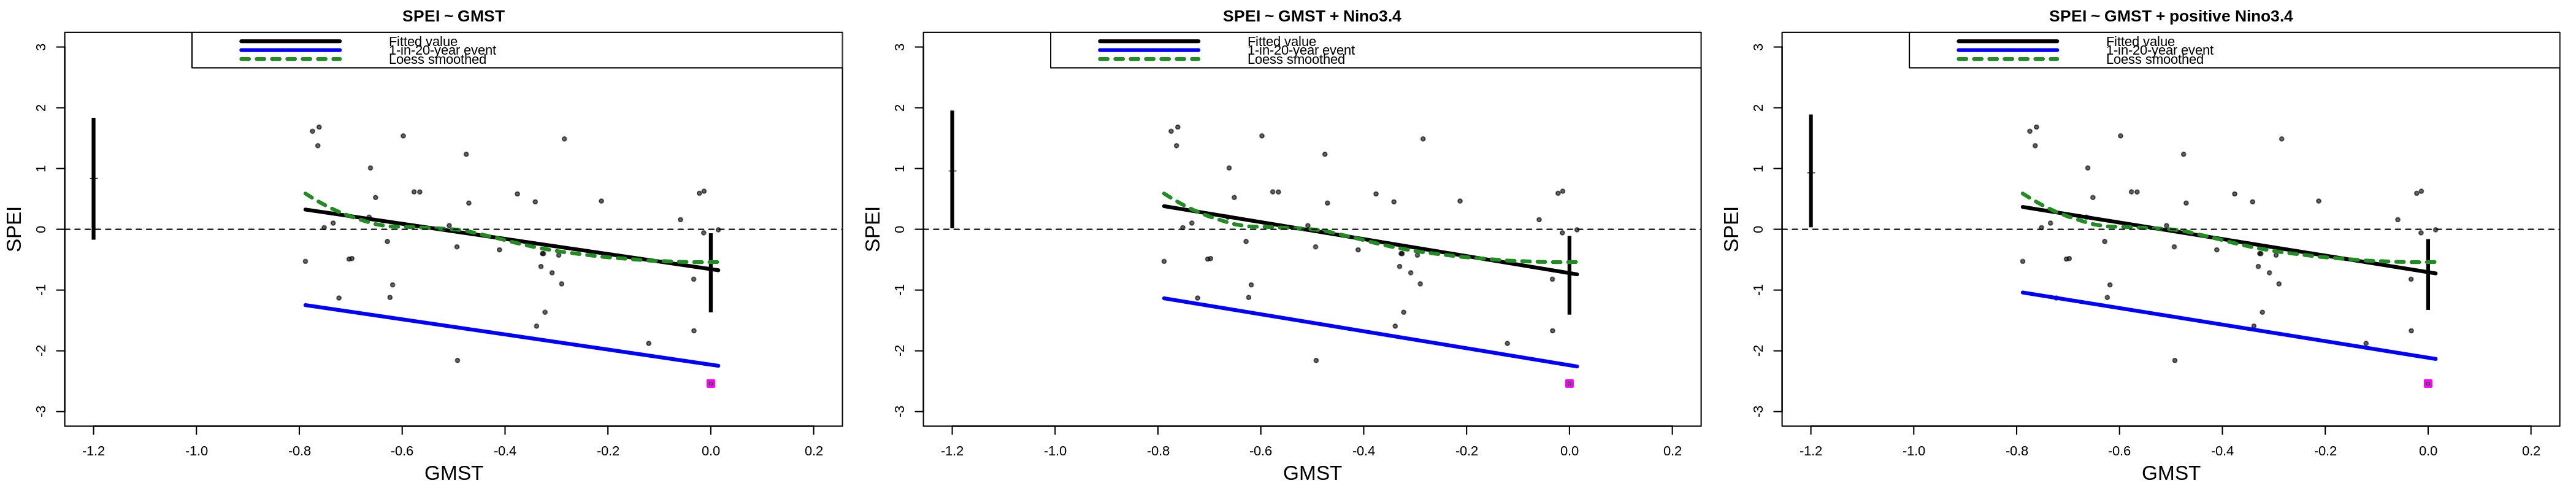

In [45]:
# all three models produce very similar fitted trend against GMST
prep_window(c(1,3), w = 7, mar = c(4,4,2,1))

plot_covtrend(mdl_gmst, "gmst", ylim = c(-3,3), rp = c(20), add_loess = T, legend = "topright", ylab = "SPEI", ci_cov = data.frame(gmst = c(0,-1.2)), main = "SPEI ~ GMST")
abline(h = 0, lty = 2)

plot_covtrend(mdl_nino, "gmst", ylim = c(-3,3), rp = c(20), add_loess = T, legend = "topright", ylab = "SPEI", ci_cov = data.frame(gmst = c(0,-1.2)), main = "SPEI ~ GMST + Nino3.4")
abline(h = 0, lty = 2)

plot_covtrend(mdl_ninopos, "gmst", ylim = c(-3,3), rp = c(20), add_loess = T, legend = "topright", ylab = "SPEI", ci_cov = data.frame(gmst = c(0,-1.2)), main = "SPEI ~ GMST + positive Nino3.4")
abline(h = 0, lty = 2)

_We can compare the two different models for accommodating El Nino. The first (using Nino3.4) is likely to overestimate SPEI in La Nina years (negative Nino index), but we can't really see what's happening with the second model, because so many values are set to 0 and the Loess smoother is distorted_

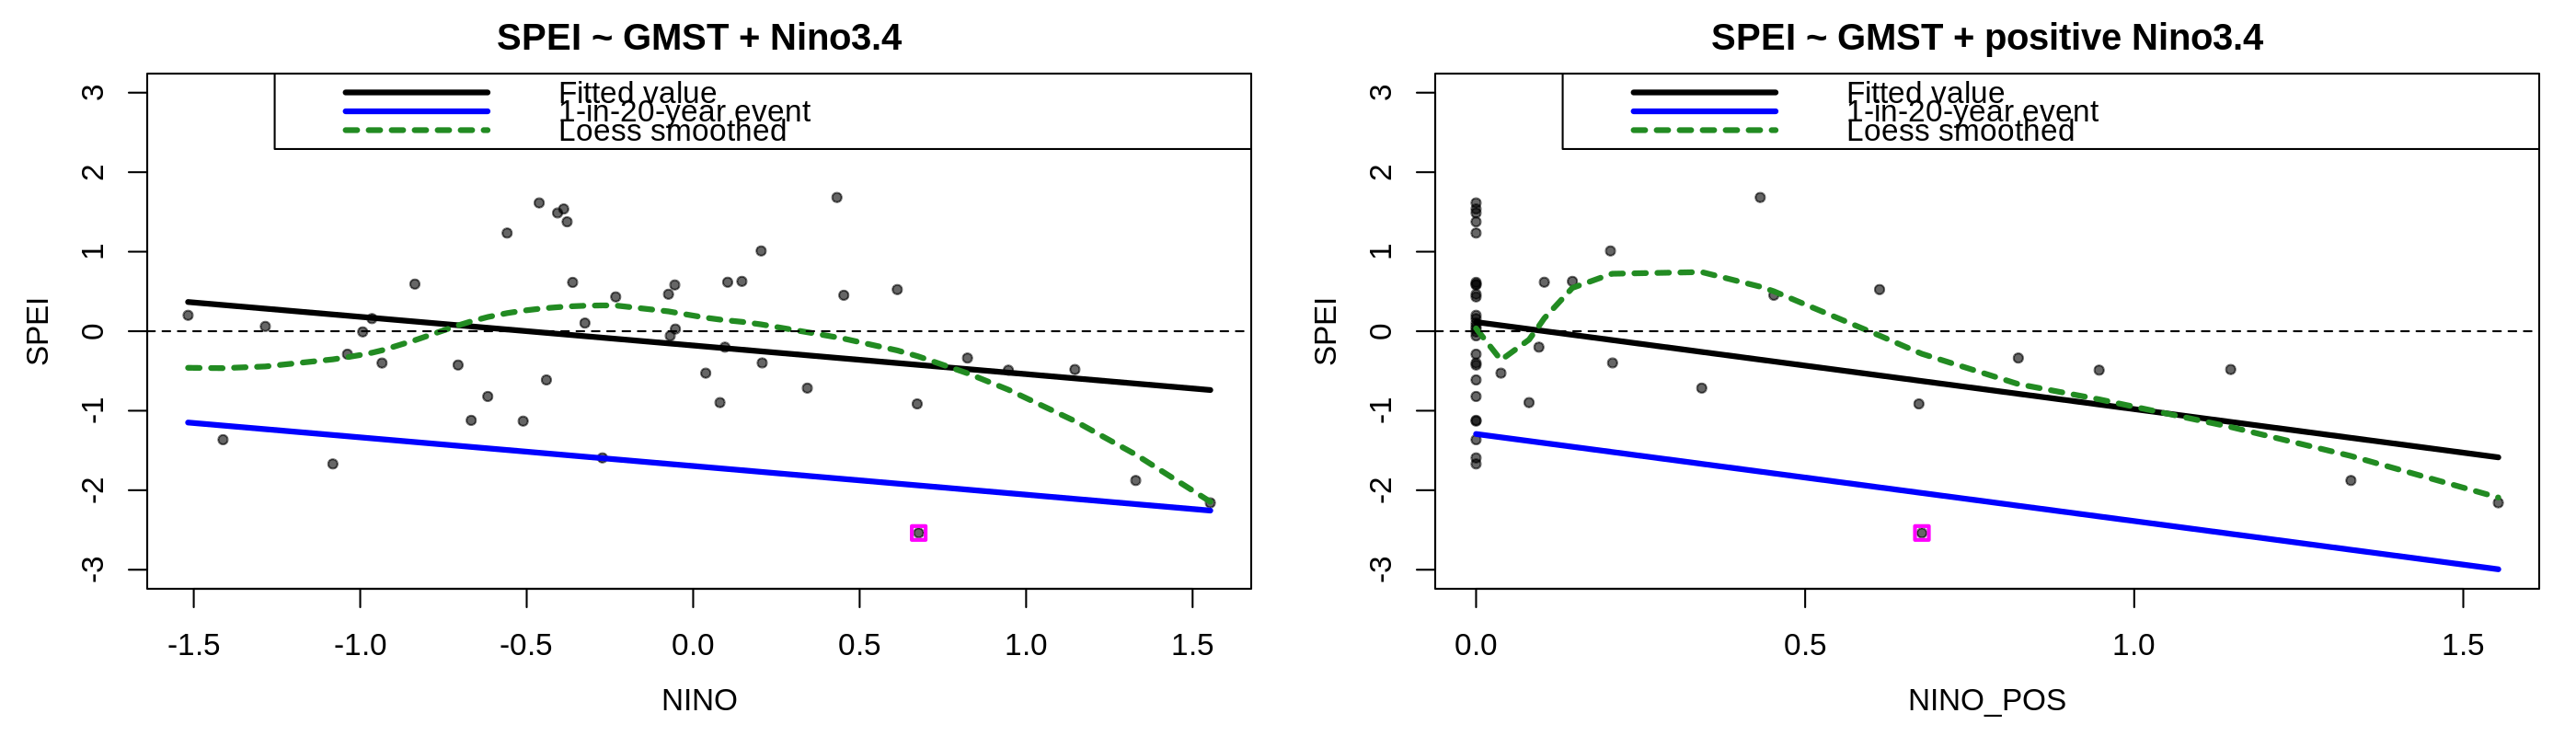

In [52]:
prep_window(c(1,2), w = 7, mar = c(4,4,2,1))

plot_covtrend(mdl_nino, "nino", ylim = c(-3,3), rp = c(20), add_loess = T, legend = "topright", ylab = "SPEI", main = "SPEI ~ GMST + Nino3.4")

plot_covtrend(mdl_ninopos, "nino_pos", ylim = c(-3,3), rp = c(20), add_loess = T, legend = "topright", ylab = "SPEI", main = "SPEI ~ GMST + positive Nino3.4")

_Instead, we can plot the positive-Nino model against the 'nino' covariate, to make sure it fits the data well.  
We do this by providing a data.frame to `trend_cov`, specifying which covariates should be used to plot the trend.  
In this case, we use the 'nino' covariate for the x-axis, but the 'nino_pos' covariate as the trend covariate, with all other covariates kept at their mean level_

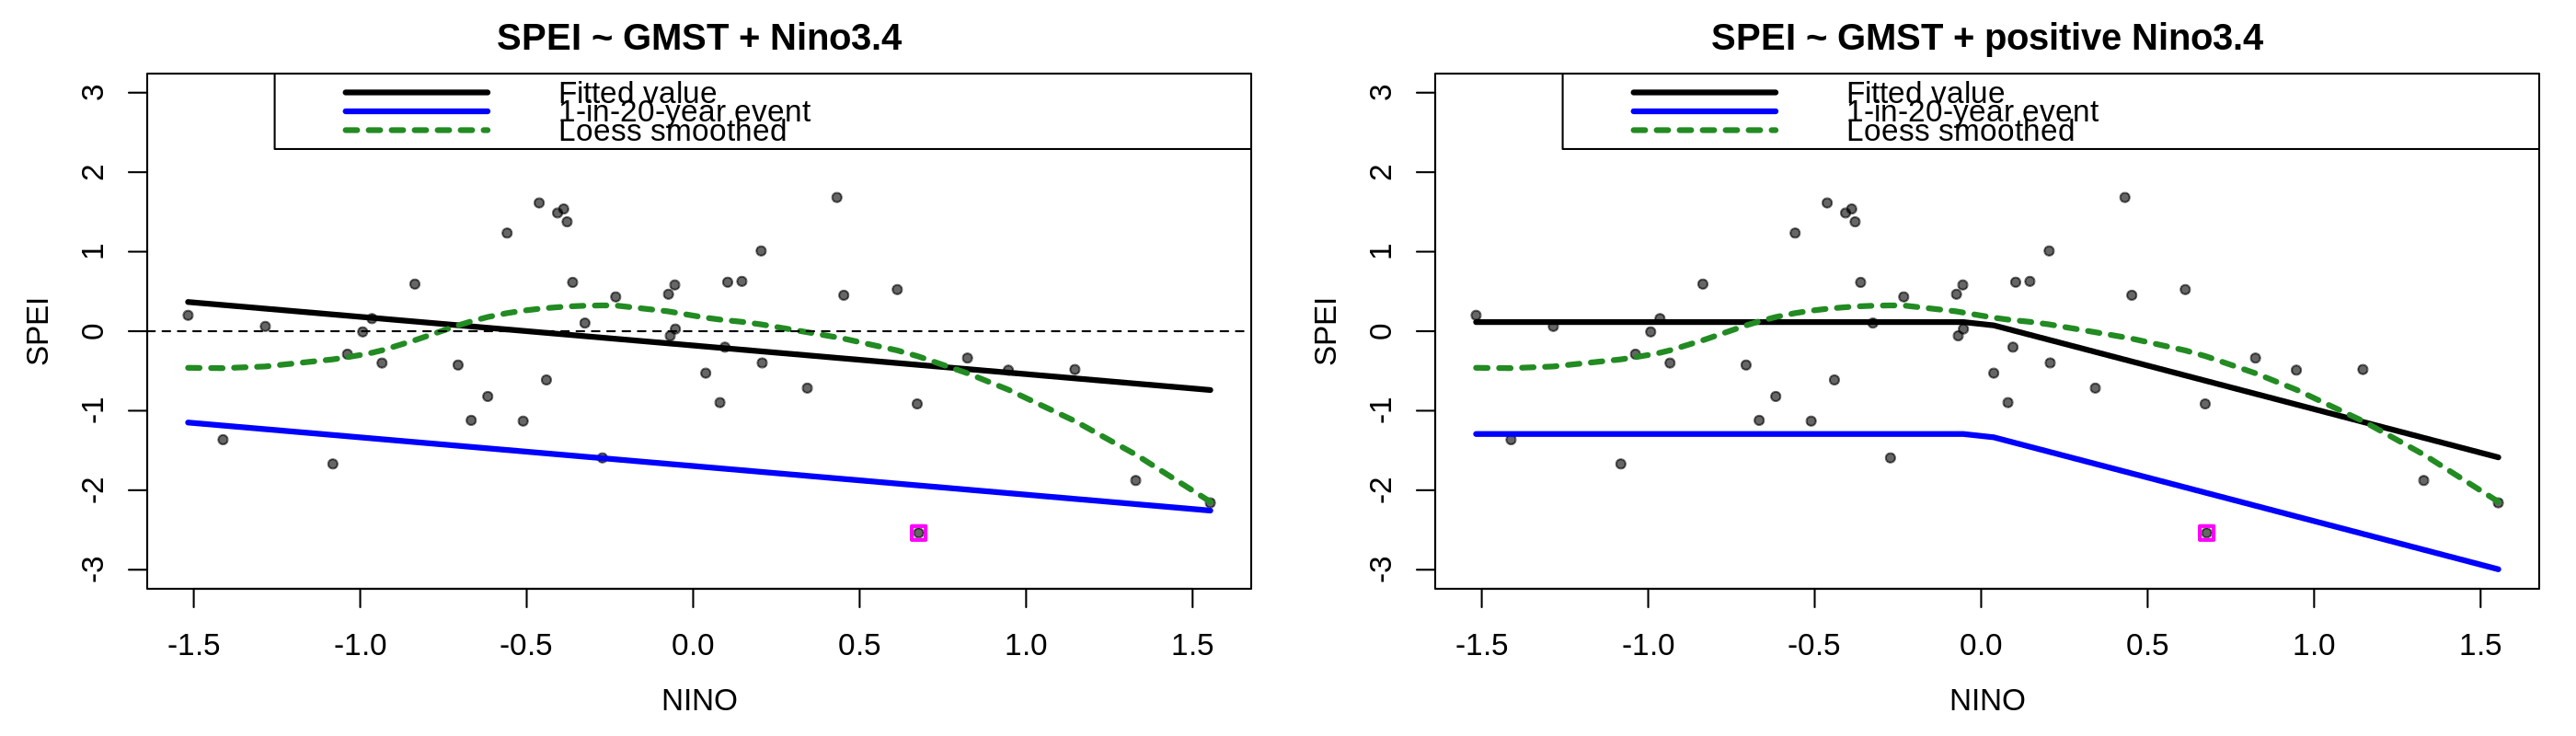

In [55]:
prep_window(c(1,2), w = 7, mar = c(4,4,2,1))

plot_covtrend(mdl_nino, "nino", ylim = c(-3,3), rp = c(20), add_loess = T, legend = "topright", ylab = "SPEI", main = "SPEI ~ GMST + Nino3.4")

# revised covariate plot:
plot_covtrend(mdl_ninopos, "nino", ylim = c(-3,3), add_loess = T, rp = c(20), legend = "topright", ylab = "SPEI", main = "SPEI ~ GMST + positive Nino3.4",
                    trend_cov = data.frame(sapply(mdl_ninopos$covnm,
                                            function(cnm) if(cnm == "nino_pos") {mdl_ninopos$data[,cnm]} else {mean(mdl_ninopos$data[,cnm])}, simplify = F)))

## Return level plots

_Return level plots are used to check whether the chosen distribution is a good choice for the data._

_First, we define a 'factual' and 'counterfactual' climate to compare and visualise the difference between the observations if they'd occurred at those values of the covariates. These must be data.frames with column names corresponding to the covariates in the specified model._

In [61]:
# our factual climate is determined by the values of the covariates in 2023
cov_2023 <- df[df$year == 2023,c("gmst", "nino", "nino_pos"),drop = F]

# we can compare several counterfactual climates:
#     - 'hist': Preindustrial climate - 1.2C cooler than today
#     - '2000': Year 2000 climate - 0.5C cooler than today
#     - 'neut': 2023 climate with neutral ENSO phase
cov_cf <- rbind("hist" = cov_2023 - c(1.2,0,0),
                "2000" = cov_2023 - c(0.5,0,0),
                "neut" = cov_2023 * c(1,0,0))

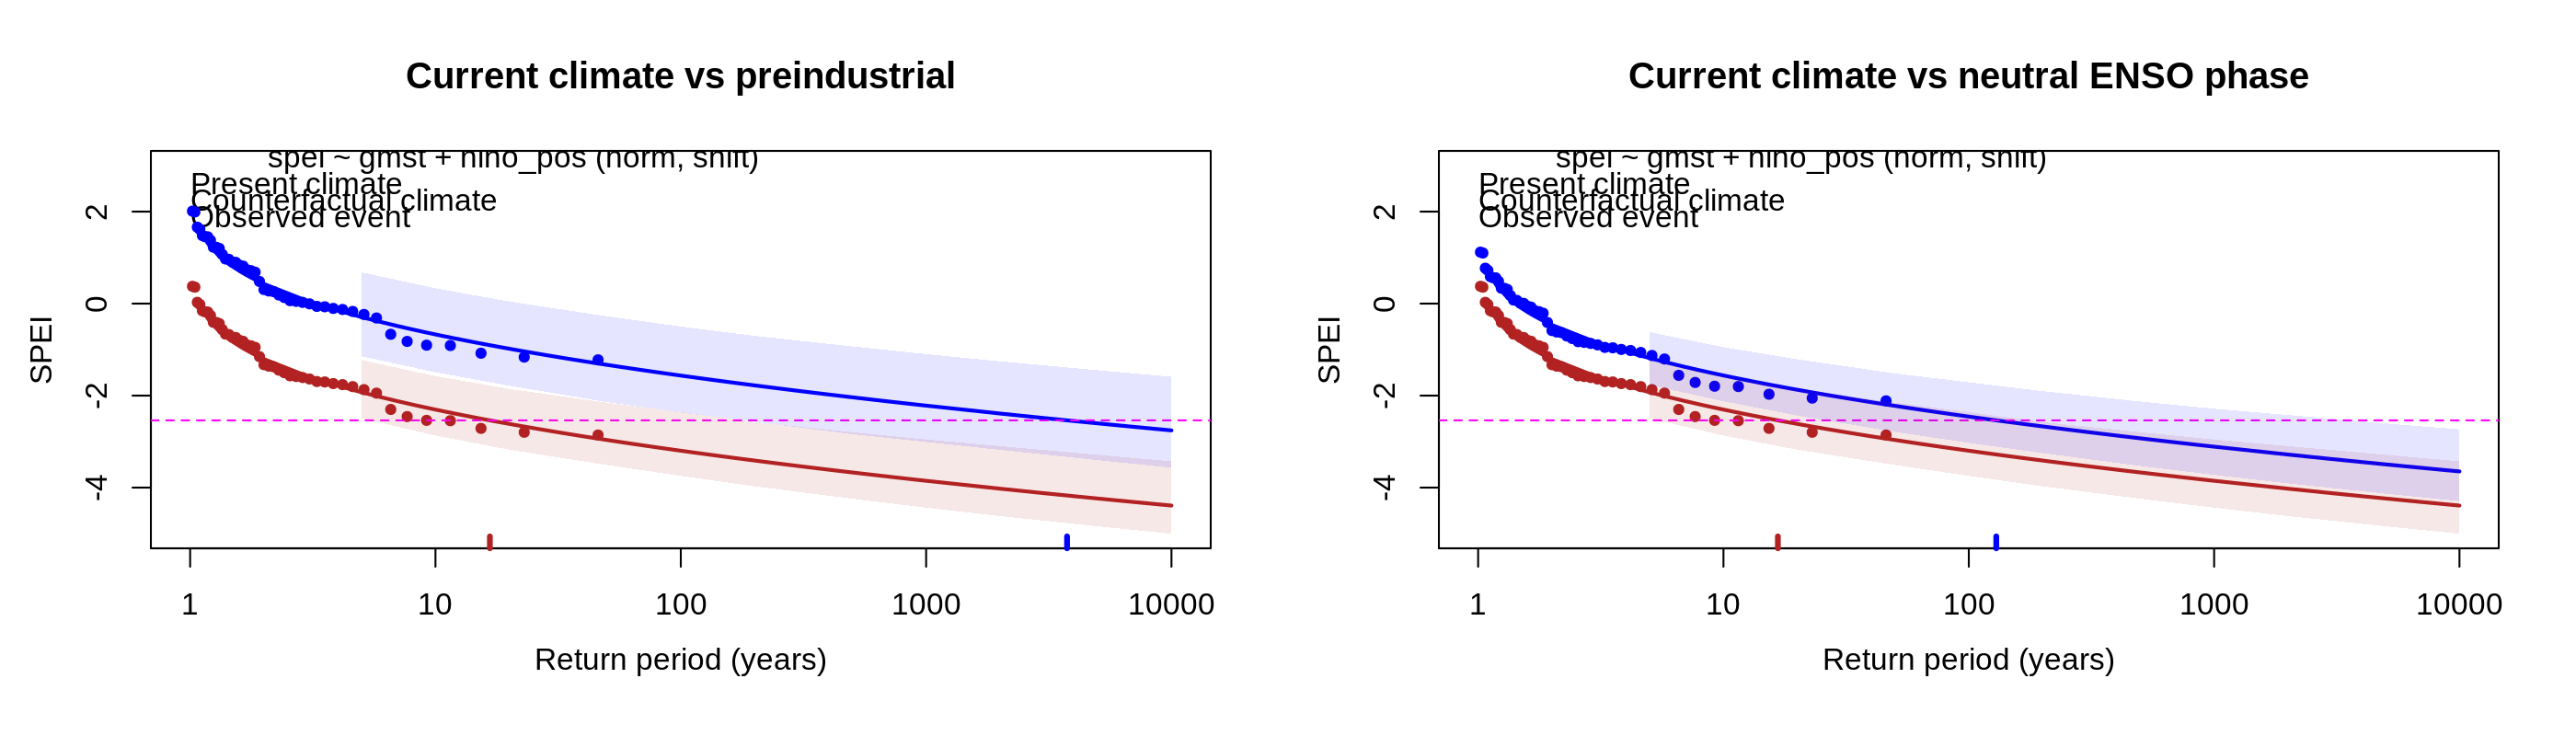

In [70]:
prep_window(c(1,2), w = 7)
ylim <- c(-5,3)

plot_returnlevels(mdl_ninopos, cov_f = cov_2023, cov_cf = cov_cf["hist",,drop = F], nsamp = 1000, ylab = "SPEI", ylim = ylim,
                  main = "Current climate vs preindustrial")

plot_returnlevels(mdl_ninopos, cov_f = cov_2023, cov_cf = cov_cf["neut",,drop = F], nsamp = 1000, ylab = "SPEI", ylim = ylim,
                  main = "Current climate vs neutral ENSO phase")

## Bootstrap model results
_Bootstrapping is used to estimate a 95% confidence interval for the quantities of interest: the model parameters, return period, and probability ratio (PR) and absolute and relative changes in intensity (dI\_abs, dI\_rel) associated with each of the counterfactual climates defined._

In [72]:
res <- boot_ci(mdl_ninopos, cov_f = cov_2023, cov_cf = cov_cf)
res

,est,2.5%,97.5%
mu0,-0.4653563,-1.1303268,3.302666e-02
sigma0,0.8559247,0.6847019,9.535624e-01
alpha_gmst,-1.3616255,-2.6009730,-2.413673e-01
alpha_nino_pos,-1.0953571,-1.5300225,-3.936890e-01
disp,-0.7089345,-1.5193167,-4.297040e-01
event_magnitude,-2.5380179,-2.5380179,-2.538018e+00
return_period,16.6631556,5.1720790,1.527569e+02
PR_hist,225.2358338,2.8798710,4.125511e+05
dI_abs_hist,-1.6339506,-3.1211676,-2.896407e-01
dI_rel_hist,180.7332843,-1357.8411680,2.300849e+03


In [76]:
# save the results for synthesis with the climate models later
write.csv(res, "res/res_spei_obs_MSWX.csv")

In [109]:
# compile the results from all observations into a single file
res <- t(sapply(list.files("res", pattern = "obs", full.names = T), function(fnm) {
    obs_res <- read.csv(fnm, row.names = "X")
    as.data.frame(t(unlist(lapply(rownames(obs_res), function(cnm) setNames(obs_res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))))
}))
rownames(res) <- sapply(strsplit(gsub(".csv", "", rownames(res)), "_"), "[", 4)
write.csv(res, "res_obs.csv")

# Fit the same nonstationary model for climate models
_We can only attribute any trends we've identified if they also occur in climate models. We therefore calculate the time series of the variable of interest and all relevant covariates for each climate model, and repeat the analysis._

_Again, we specify the factual and past counterfactual climates: for climate models, as well as evaluating changes between the counterfactual and present climates using the counterfactual as a baseline, we also evaluate changes between the current and future climates by specifying `cov_fut`: this uses the current climate as the baseline for the changes._

_Things are a little more complicated because we're using El Nino as a covariate, and we want the 'factual' climate to reflect the real-world 2023 El Nino conditions. We therefore standardise all Nino indices so that 1979-2024 (the 'observed' time period) has mean 0 and standard deviation 1. We then use the 2023 standardised El Nino covariate to define the 'factual' climate._

In [ ]:
# load observed Nino covariate & standardise wrt obs period
nino_obs <- read.csv("ts/nino_6monthly.csv", col.names = c("year", "nino"))

nino_cal <- nino_obs$nino[(nino_obs$year >= 1979) & (nino_obs$year <= 2024)]
nino_obs$nino_std <- (nino_obs$nino - mean(nino_cal)) / sd(nino_cal)

nino_2023 <- nino_obs$nino_std[nino_obs$year == 2023] #' this is our 'factual' Nino state

In [ ]:
rp <- 15

# list all the available climate model time series
for(fnm in list.files("ts", pattern = "spei_SAM", full.names = T)) {
    
    # extract filenames etc
    res_fnm <- gsub("ts/", "res/res_", gsub(".dat", ".csv", fnm))
    model_name = paste0(strsplit(fnm, "_")[[1]][c(3,5)], collapse = "_")
    gcm <- strsplit(fnm, "_")[[1]][3]
    
    # identify the corresponding smoothed GMST and 6-month Nino files
    gmst_fnm <- list.files("ts", paste0("smoothed-gsat_", gcm), full.names = T)
    nino_fnm <- list.files("ts", paste0("nino34det_.+", gcm), full.names = T)
    
    # load data
    var <- load_ts(fnm, col.names = c("year", "spei"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    nino <- load_ts(nino_fnm, col.names = c("year", "nino"))
    
    # standardise Nino values to use as covariate
    nino_cal <- nino$nino[(nino$year >= 1979) & (nino$year <= 2024)]
    nino$nino_std <- (nino$nino - mean(nino_cal)) / sd(nino_cal)
    nino$nino_std[nino$nino_std < 0] <- 0
    
    # merge into single dataframe
    df <- merge(merge(gmst, nino), var)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # SPECIFY MODEL TO BE ANALYSED

    # value of covariate in present/factual climate
    gmst_2023 = df$gmst[df$year == 2023]
    
    cov_2023 <- data.frame(gmst = gmst_2023, nino_std = nino_2023)
    cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0),
                    "neut" = c(gmst = gmst_2023, 0))
    cov_fut <- cov_2023 + c(0.8, 0)

    # fit the model - this is used as a template for the attribution
    mdl <- fit_ns("norm", "shift", df, "spei", c("gmst", "nino_std"), lower = T)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # compute the climate model results
    res_df <- cmodel_results(mdl, rp = rp, cov_f = cov_2023, cov_hist = cov_cf, cov_fut = cov_fut, nsamp = 1000, y_start = 1979, y_now = 2023, y_fut = 2050)
    write.csv(res_df, res_fnm)

}

_Once the model fitting has been repeated for all climate models, we can compile the results into a single .csv for easier handling_

In [1]:
# compile results
res <- t(sapply(list.files("res", pattern = "SAM", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) paste0(strsplit(rnm, "_")[[1]][c(4,6)], collapse = "_"))
write.csv(res, "res_cordex.csv")

# Synthesis

_Having evaluated the changes in likelihood and frequency of the specified event in both the observations and the climate models, we now combine the two sets of results to produce a single overarching attribution statement._

_This script uses output from the functions above, but the function only requires that you provide, for the models and (optionally) observations, a data.frame with row.names indicating the model names, and columns containing the best estimate and lower and upper confidence bounds of the quantity to be synthesised (either a PR or a change in intensity)._

_The synthesis algorithm produces a precision-weighted average of the models and (if using) the observations, then provides a precision weighted average (purple bar) and unweighted average (white bar) of the two sets of data. For a more detailed explanation of the calculation, see Otto et al., Formally combining different lines of evidence in extreme event attribution; Advances in Statistical Climatology, Meteorology and Oceanography (2024)._

In [111]:
obs_res <- read.csv("res_obs.csv", row.names = "X")
model_res <- read.csv("res_cordex.csv", row.names = "X")

In [119]:
synth_pr_attr <- synthesis(obs_res[,grepl("PR.hist", colnames(obs_res))], model_res[,grepl("attr_PR.hist", colnames(model_res))], synth_type = "PR")
synth_dI_attr <- synthesis(obs_res[,grepl("dI.abs.hist", colnames(obs_res))], model_res[,grepl("attr_dI.abs.hist", colnames(model_res))])

synth_pr_neut <- synthesis(obs_res[,grepl("PR.neut", colnames(obs_res))], model_res[,grepl("attr_PR.neut", colnames(model_res))], synth_type = "PR")
synth_dI_neut <- synthesis(obs_res[,grepl("dI.abs.neut", colnames(obs_res))], model_res[,grepl("attr_dI.abs.neut", colnames(model_res))])

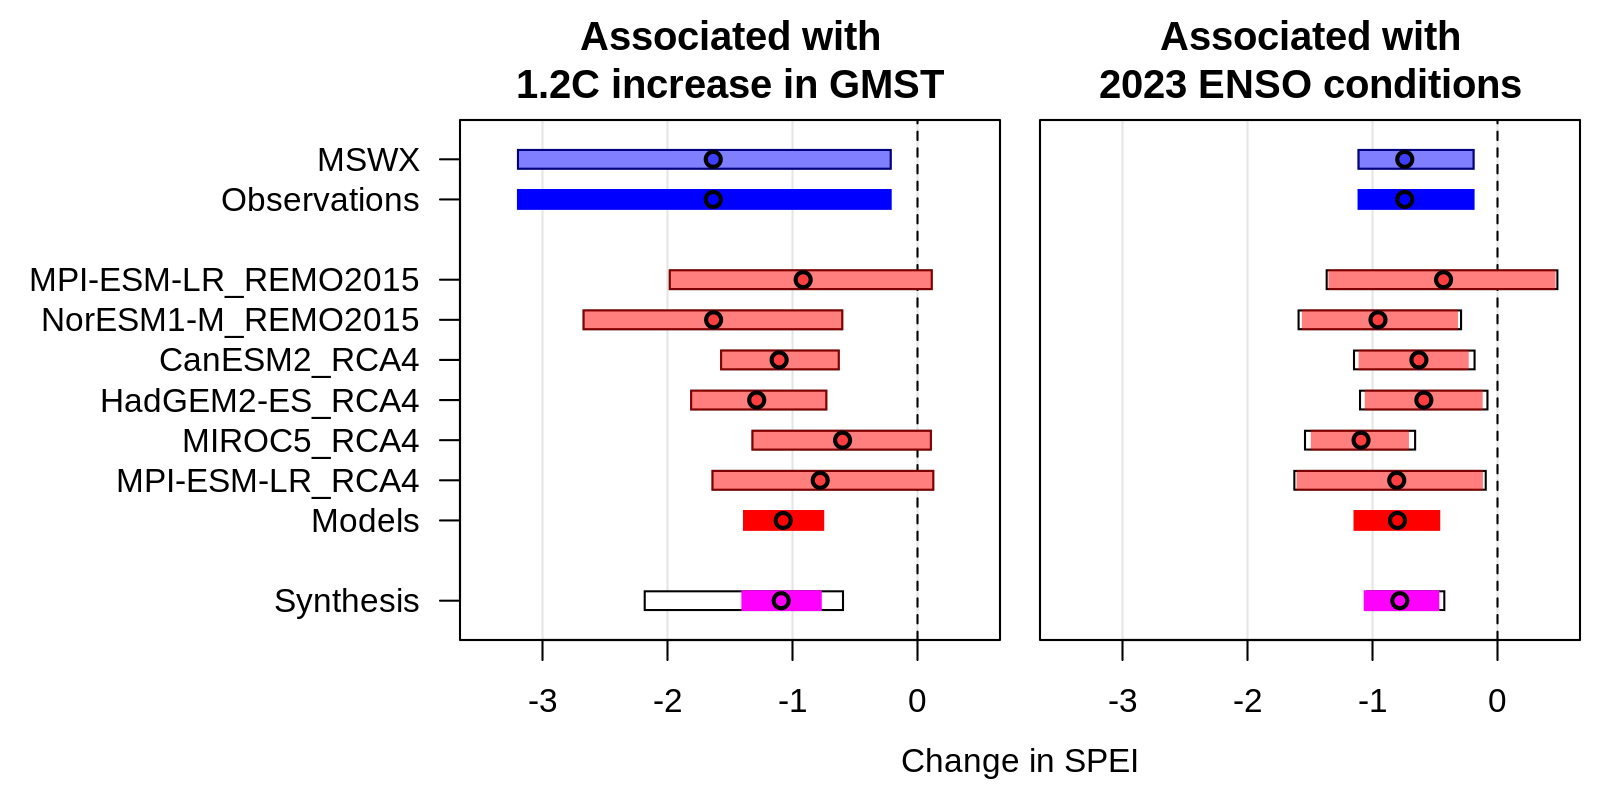

In [120]:
prep_window(c(1,2), mar = c(2,0.5,3,0.5), oma = c(2,11,0,0))

    plot_synthesis(synth_dI_attr, xlim = c(-3.5,0.5), main = "Associated with\n1.2C increase in GMST")
    plot_synthesis(synth_dI_neut, xlim = c(-3.5,0.5), main = "Associated with\n2023 ENSO conditions", hide_labels = T)

    mtext("Change in SPEI", 1, outer = T, line = 0.5)

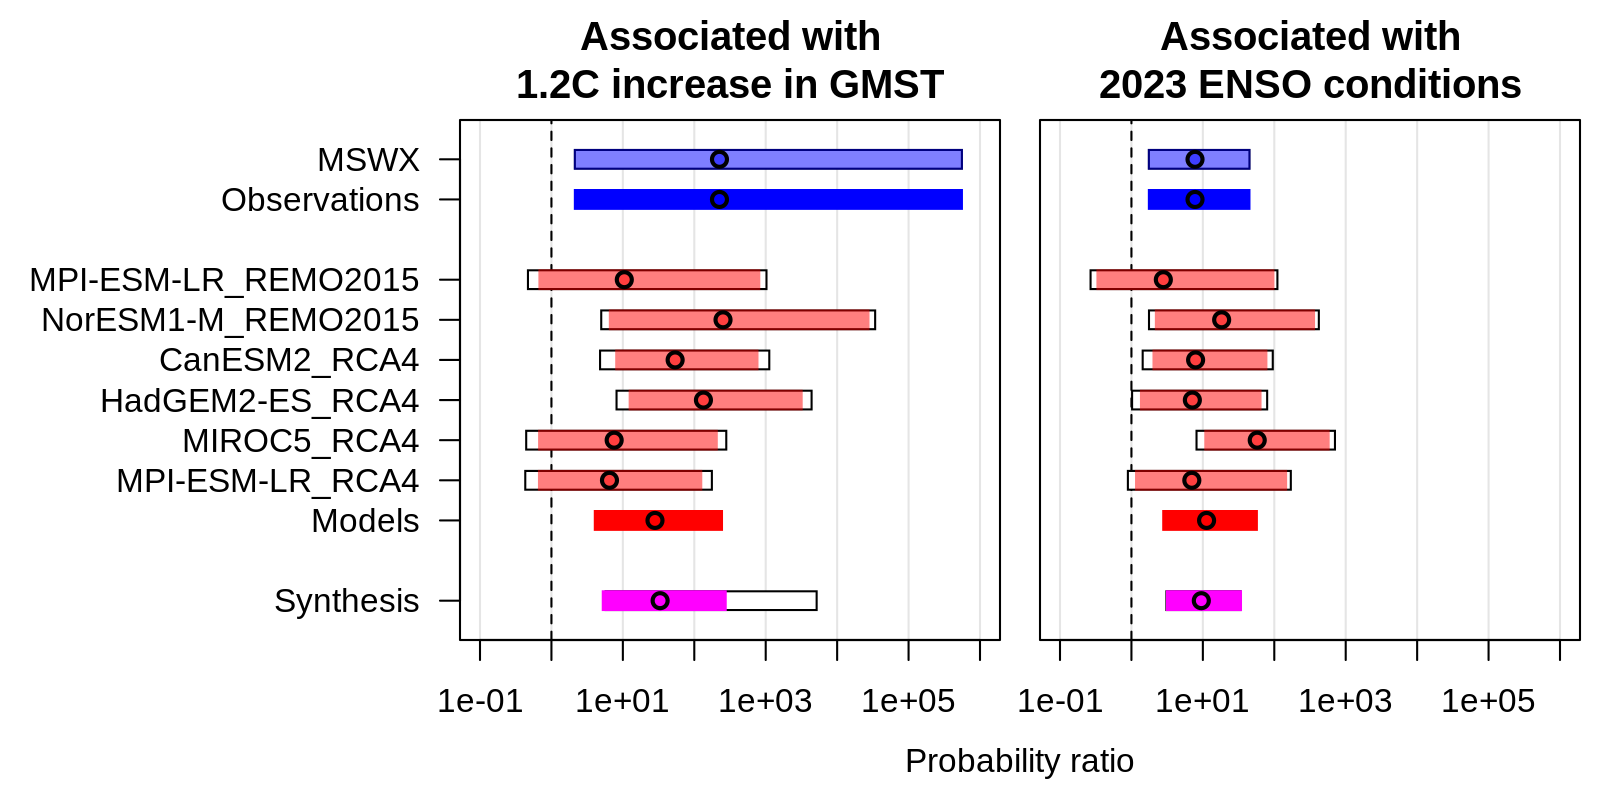

In [122]:
prep_window(c(1,2), mar = c(2,0.5,3,0.5), oma = c(2,11,0,0))
    
    plot_synthesis(synth_pr_attr, xlim = c(1e-1, 1e+6), main = "Associated with\n1.2C increase in GMST")
    plot_synthesis(synth_pr_neut, xlim = c(1e-1, 1e+6), main = "Associated with\n2023 ENSO conditions", hide_labels = T)

    mtext("Probability ratio", 1, outer = T, line = 0.5)